<a href="https://colab.research.google.com/github/PunDin0827/Shor-cut-CNN/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*在CNN中加入short cut方法(用於CIFAR10資料集)*

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

*載入資料集*



In [ ]:
# 資料轉換
transform = transforms.Compose(
    [transforms.ToTensor(), # 轉換為Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 正規化圖像，使其範圍介於[-1, 1]之間
    ])

batch_size = 1000 # 批次大小

# 下載並加載訓練資料集
train_ds = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

# 下載並加載測試資料集
test_ds = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

100%|██████████| 170498071/170498071 [00:03<00:00, 42706906.37it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck')

*顯示圖片資料*

torch.Size([8, 3, 32, 32])


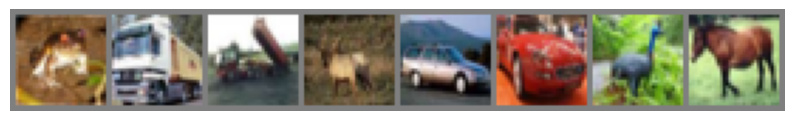

frog  truck truck deer  car   car   bird  horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 圖像顯示函數
def imshow(img):
    img = img * 0.5 + 0.5  # 還原圖像
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 顏色換至最後一維
    plt.axis('off') # 關閉座標軸
    plt.show()


# 取一批資料
batch_size_tmp = 8
train_loader_tmp = torch.utils.data.DataLoader(train_ds, batch_size=batch_size_tmp)
dataiter = iter(train_loader_tmp)
images, labels = next(dataiter)
print(images.shape)

# 顯示圖像
plt.figure(figsize=(10,6))
imshow(torchvision.utils.make_grid(images))
# 顯示類別
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size_tmp)))

*建立殘差模組*

In [ ]:
# 定義ResNet中的殘差模組
class ResBlk(nn.Module):
  #resnet bolck
    def __init__(self,in_channel,out_channel,stride=1):
        super(ResBlk,self).__init__()
        self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.extra = nn.Sequential()
        if in_channel != out_channel:
          self.extra = nn.Sequential(
              nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=stride),
              nn.BatchNorm2d(out_channel)
          )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        #element wise add: [b,in_channel,h,w] with [b,out_channel,h,w]
        out = self.extra(x) + out # shortcut連接
        out = F.relu(out)

        return out

*建立模型*

In [ ]:
# 定義ResNet18模型
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18,self).__init__()

    self.conv1 = nn.Sequential(
       nn.Conv2d(3 ,64,kernel_size=3,stride=3,padding=0),
       nn.BatchNorm2d(64)
    )
    #followed 4 block ,
    #[b,64,h,w]=>[b,128,h,w]
    self.blk1 = ResBlk(64,128,stride=2)
    #[b,128,h,w]=>[b,256,h,w]
    self.blk2 = ResBlk(128,256,stride=2)
    #[b,256,h,w]=>[b,512,h,w]
    self.blk3 = ResBlk(256,512,stride=2)
    #[b,512,h,w]=>[b,512,h,w]
    self.blk4 = ResBlk(512,512,stride=2)

    self.outlayer = nn.Linear(512*1*1,10)

  def forward(self,x):
      x = F.relu(self.conv1(x))
      #[b,64,h,w]=>[b,512,h,w]
      x = self.blk1(x)
      x = self.blk2(x)
      x = self.blk3(x)
      x = self.blk4(x)
      x = F.adaptive_avg_pool2d(x,[1,1])
      x = x.reshape(x.size(0),-1)
      x = self.outlayer(x)

      return x


*訓練模型*

In [ ]:
# 定義訓練函數
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad() # 梯度清零
        output = model(data)  # 前向傳播
        loss = criterion(output, target) # 計算損失
        loss_list.append(loss.item())
        loss.backward() # 反向傳播
        optimizer.step() # 更新參數

        if (batch_idx+1) % 10 == 0:
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}]   Loss: {loss.item():.6f}')
    return loss_list

In [ ]:
# 定義測試函數
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()


    test_loss /= len(test_loader.dataset) # 平均損失
    data_count = len(test_loader.dataset)
    percentage = 100. * correct / data_count
    print(f'準確率: {correct}/{data_count} ({percentage:.2f}%)')

In [ ]:
epochs = 10 # 訓練輪數
lr=0.1 # 學習率

model = ResNet18().to(device) # 初始化模型

criterion = nn.CrossEntropyLoss() # 定義損失函數

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 定義優化器

loss_list = []
for epoch in range(1, epochs + 1):
    loss_list += train(model, device, train_loader, criterion, optimizer, epoch)

Epoch 1: [10000 / 50000]   Loss: 2.294601
Epoch 1: [20000 / 50000]   Loss: 1.998417
Epoch 1: [30000 / 50000]   Loss: 1.868415
Epoch 1: [40000 / 50000]   Loss: 1.658285
Epoch 1: [50000 / 50000]   Loss: 1.579355
Epoch 2: [10000 / 50000]   Loss: 1.570406
Epoch 2: [20000 / 50000]   Loss: 1.425424
Epoch 2: [30000 / 50000]   Loss: 1.360928
Epoch 2: [40000 / 50000]   Loss: 1.343340
Epoch 2: [50000 / 50000]   Loss: 1.279738
Epoch 3: [10000 / 50000]   Loss: 1.245848
Epoch 3: [20000 / 50000]   Loss: 1.137715
Epoch 3: [30000 / 50000]   Loss: 1.146169
Epoch 3: [40000 / 50000]   Loss: 1.215678
Epoch 3: [50000 / 50000]   Loss: 1.117612
Epoch 4: [10000 / 50000]   Loss: 1.078237
Epoch 4: [20000 / 50000]   Loss: 0.960060
Epoch 4: [30000 / 50000]   Loss: 0.996586
Epoch 4: [40000 / 50000]   Loss: 0.982447
Epoch 4: [50000 / 50000]   Loss: 0.956554
Epoch 5: [10000 / 50000]   Loss: 0.854030
Epoch 5: [20000 / 50000]   Loss: 0.897273
Epoch 5: [30000 / 50000]   Loss: 0.828728
Epoch 5: [40000 / 50000]   Loss: 0

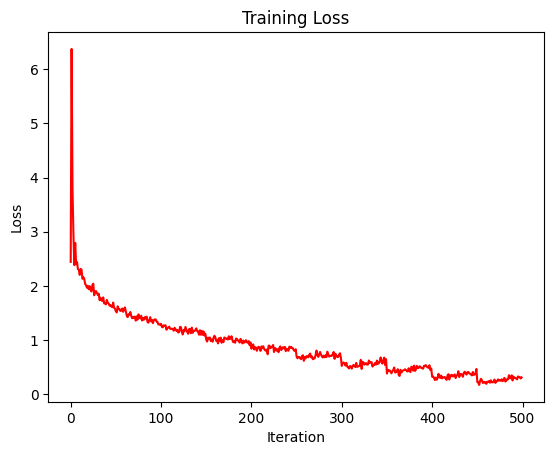

In [ ]:
# 繪製訓練過程中的損失
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
test(model, device, test_loader)  # 測試模型

準確率: 6868/10000 (68.68%)


*測試一批資料*

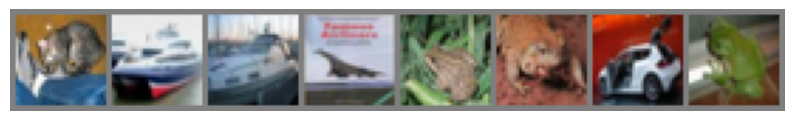

真實類別:  cat   ship  ship  plane frog  frog  car   frog 
預測類別:  dog   ship  ship  plane frog  frog  car   bird 


In [ ]:
batch_size=8
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 顯示圖像
plt.figure(figsize=(10,6))
imshow(torchvision.utils.make_grid(images))

print('真實類別: ', ' '.join(f'{classes[labels[j]]:5s}'
                         for j in range(batch_size)))

# 預測
outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print('預測類別: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

In [ ]:
# 初始化各類別的正確數
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 預測
batch_size=1000
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    outputs = model(data)
    _, predictions = torch.max(outputs, 1)
    # 計算各類別的正確數
    for label, prediction in zip(target, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


# 計算各類別的準確率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{classname:5s}: {accuracy:.1f} %')

plane: 75.7 %
car  : 84.8 %
bird : 64.3 %
cat  : 44.7 %
deer : 53.3 %
dog  : 57.9 %
frog : 77.6 %
horse: 79.1 %
ship : 74.9 %
truck: 74.5 %
